# Chapter 4. Neural network training

## Cost functions

- Sum of squares for error (SSE) <br>
$
E = \frac{1}{2} \sum_{k} (y_k - t_k)^2 .
$<br>
($y_k$ : output values, $t_k$ : answer labels, $k$ : data dimensions. \[$k=10$ for MNIST classification problem\] )

- Cross entropy (Cross entropy error, CEE) <br>
$
E = -\sum_{k} t_k \log{y_k} .
$<br>
Cross entropy is minimized when $t_k = y_k$. 

*NOTE : cross entropy takes non-negative values as $0\leq y_k \leq 1$.*

In [1]:
# SSE definition with numpy
def sum_squares_error(y, t):
    return 0.5 * np.sum((y - t)**2)

# Cross entropy definition with numpy
def cross_entropy(y, t):
    delta = 1e-7  # Delta introduced to avoid overflow in log function.
    return -np.sum(t*np.log(y+delta))

When we have $N$ data for training (batch training), the definition of cost function is changed to below:

- Cross entropy (Cross entropy error, CEE) <br>
$
E = - \frac{1}{N} \sum^{N}_{n} \sum_{k} t_{nk} \log{y_{nk}} .
$<br>
(subscript $n$ denotes the $n$th training data in the batch.) 

## Mini-batch training

When we have 60000 training data, calculating the cost function would be too heavy to deal with. <br>
So we pick 100 data randomly and approximate them to represent total set. <br>
It is called ***Mini-batch training***. 

In [3]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size,batch_size) # Randomly choose indices. 
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [6]:
def cross_entropy(y, t):
    '''
    If input is a single data, we reshape it.
    Else, shape of y and t would be (N, D).
    N : number of data in the batch
    D : label dimension. (i.e. D = 10 for one-hot-encoded MNIST data)
    '''
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshpae(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t* np.log(y+1e-7)) / batch_size


# # When label is number label (i.e. t = 0, 1, 2, ..., 9), cross entropy is defined by
# def cross_entropy(y, t):
#     '''
#     If input is a single data, we reshape it.
#     Else, shape of y and t would be (N, D).
#     N : number of data in the batch
#     D : label dimension. (i.e. D = 10 for one-hot-encoded MNIST data)
#     '''
#     if y.ndim == 1:
#         t = t.reshape(1, t.size)
#         y = y.reshpae(1, y.size)
    
#     batch_size = y.shape[0]
#     return -np.sum(np.log(y[np.arange(batch_size),t] + 1e-7)) / batch_size
# """

Cost function is introduced because it is easily **differentiable**.

Differential of Accuracy is 0 at most point: <br>
Accuracy is discrete indicators. So small change in weight parameters may not change the accuracy.

However, cost function is continuously varied as the output of activation function is varied 
when the weights are tuned. 

## Numerical differentiation and Gradient-descent

$
\frac{df(x)}{dx} = \lim_{h \to 0} \frac{f(x+h) - f(x)}{h} . 
$

In [7]:
def numerical_diff(f,x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

In [12]:
# Gradient for multi-variable function f(x)

def numerical_grad(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    for i in range(x.size):
        tmp = x[i]
        # f(x+h)
        x[i] = tmp + h
        fxh1 = f(x)
        
        # f(x-h)
        x[i] = tmp - h
        fxh2 = f(x)
        
        grad[i] = (fxh1 - fxh2) / (2*h)
        x[i] = tmp
        
    return grad

In [14]:
# Gradient-descent

def grad_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_hist = []
    
    for i in range(step_num):
        x_hist.append(x.copy())
        grad = numerical_grad(f,x)
        x -= lr * grad
        
    return x, np.array(x_hist)

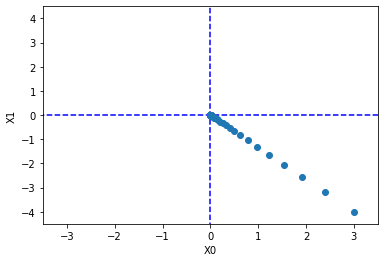

In [17]:
def func_2(x):
    return x[0] ** 2 + x[1] ** 2

init_x = np.array([3.0,-4.0])

x, x_hist = grad_descent(func_2, init_x=init_x, lr=0.1, step_num=100)

import matplotlib.pyplot as plt

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_hist[:,0], x_hist[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

In [1]:
# Calculating the gradient in the neural network

import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax, cross_entropy
from common.gradient import numerical_grad

# simpleNet : input 2 nodes, output 3 nodes.
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3)
        
    def predict(self,x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy(y, t)
        
        return loss

In [2]:
x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)
dW = numerical_grad(f, net.W)

print(dW)

[[ 0.12943753  0.26471779 -0.39415532]
 [ 0.19415629  0.39707668 -0.59123298]]


In [1]:
# Two-layer network implementation
# 1 Hidden layer, 1 output layer

import sys, os
sys.path.append(os.pardir)

from common.functions import *
from common.gradient import numerical_grad

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,
                weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x,W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1,W2) + b2
        y = softmax(a2)
        
        return y
    
    # t : answer label
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        # Among the output and answer label, pick the largest ones. 
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum( y == t ) / float(x.shape[0])
        return accuracy
    
    def numerical_grad(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
 
        grads['W1'] = numerical_grad(loss_W, self.params['W1'])

        grads['b1'] = numerical_grad(loss_W, self.params['b1'])

        grads['W2'] = numerical_grad(loss_W, self.params['W2'])

        grads['b2'] = numerical_grad(loss_W, self.params['b2'])

        
        return grads
    
    def grad(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        batch_size = x.shape[0]
        
        # Forward propagation
        a1 = np.dot(x,W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1,W2) + b2
        y = softmax(a2)
        
        grads = {}
        # Backward propagation
        dy = (y - t) / batch_size
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

2.292522321959677
train acc, test acc | 0.09035, 0.0892
0.9170531314481509
train acc, test acc | 0.7819333333333334, 0.7844
0.5907183395956388
train acc, test acc | 0.8709333333333333, 0.877
0.3590550318307312
train acc, test acc | 0.8977833333333334, 0.8997
0.3207262307365392
train acc, test acc | 0.9078, 0.9107
0.43505023621044697
train acc, test acc | 0.9150833333333334, 0.918
0.14430513738061573
train acc, test acc | 0.9194833333333333, 0.9212
0.41977725079816525
train acc, test acc | 0.9244333333333333, 0.9271
0.3019660145632171
train acc, test acc | 0.9281, 0.9286
0.18210175412754345
train acc, test acc | 0.93135, 0.9323
0.14389177375154008
train acc, test acc | 0.9346166666666667, 0.9355
0.27668614595364865
train acc, test acc | 0.9365833333333333, 0.9372
0.1486213096925693
train acc, test acc | 0.9391833333333334, 0.9399
0.17325916209772804
train acc, test acc | 0.94115, 0.9417
0.30308640536828807
train acc, test acc | 0.94395, 0.9432
0.20697942593947258
train acc, test acc | 0

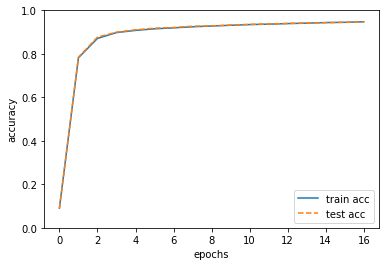

In [2]:
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train) , (x_test, t_test) = \
    load_mnist(flatten=True, normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784,hidden_size=50,output_size=10)

iter_per_epoch = max(int(train_size / batch_size), 1)

# Mini-batch training
for i in range(iter_num):
    batch_mask = np.random.choice(train_size,batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # gradient
    grad = network.grad(x_batch, t_batch)
    
    # updating weights
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # Change of loss function stacked
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        print(loss)
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        
import matplotlib.pyplot as plt

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()